## Overview

#### Steps

- Extract entities
- Topic modelling
- Knowledge search

### Algorthmic building blocks

### Textual data

Read textual data and add structured metadata using Dependency parsing -> POS-tagging.

Subj -> Verb <- Object 

This (nsubj) is (verb) a (det) sentence (attr)

### Semantic triple

(Subject, Predicate, Object) - RDF- w3C


## Preprocessing data

Criteria for good dataset

- Long well written texts covering divers topics
- Extensive and well maintained
- Available

### Eploratory Data Analysis

In [1]:
from pathlib import Path
import pandas as pd

In [2]:
root_dir = Path.cwd()
root_dir

WindowsPath('c:/Users/j.simbananiye/Documents/code/personal/knowledge-graphs')

In [3]:
%matplotlib inline

In [4]:
# Read csv
data_file = root_dir / 'data' / 'wiki_movie_plots_deduped.csv'
movie_plots_data = pd.read_csv(data_file)

In [5]:
movie_plots_data.shape

(34886, 8)

In [6]:
movie_plots_data.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


### country of origin

<AxesSubplot:ylabel='Origin/Ethnicity'>

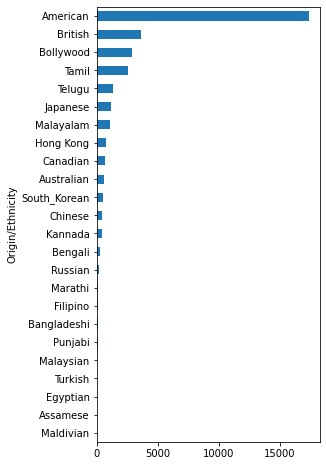

In [7]:
movie_plots_data.groupby(['Origin/Ethnicity']).size().sort_values(ascending=True).plot.barh(figsize=(4,8))

In [8]:
# most movies are American/ British - western - Bias

### Visualize release year trend

<AxesSubplot:xlabel='Release Year'>

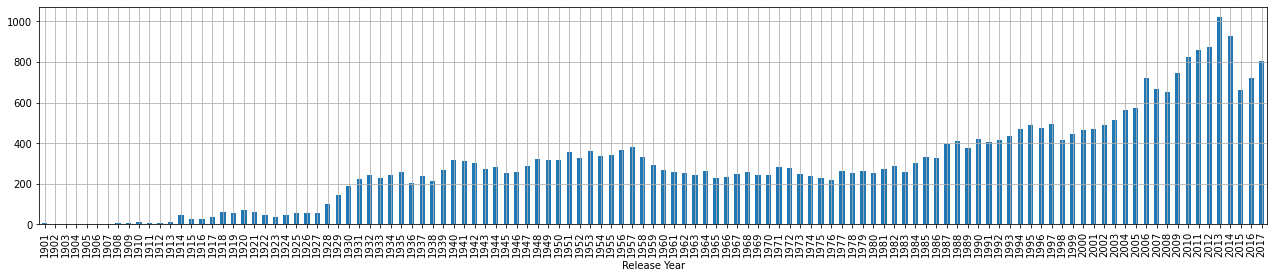

In [9]:
movie_plots_data.groupby(["Release Year"]).size().plot(kind='bar', figsize=(22,4), grid=True)

### Visualize genre breakdown

<AxesSubplot:ylabel='Genre'>

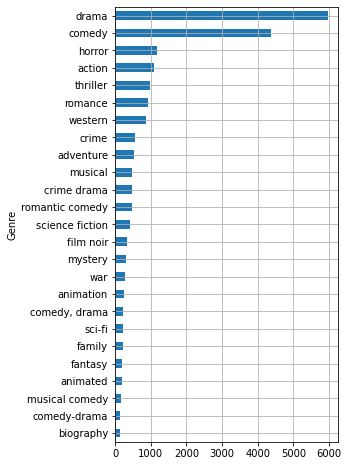

In [10]:
movie_plots_data[movie_plots_data['Genre'] != 'unknown'].groupby(['Genre']).size().sort_values(ascending=True).tail(25).plot.barh(figsize=(4,8), grid=True)

In [11]:
# TODO ignore both ('unknown'/ 'Unknown') types
# Suggests exponential distribution on num of movies per genre

### Visualize director movie count

<AxesSubplot:ylabel='Director'>

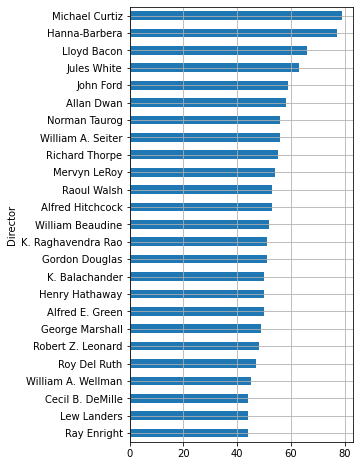

In [12]:
movie_plots_data[movie_plots_data['Director'] != 'Unknown'].groupby(['Director']).size().sort_values(ascending=True).tail(25).plot.barh(figsize=(4,8), grid=True)

### Get subset of data released after 2005

In [13]:
data_subset = movie_plots_data[movie_plots_data['Release Year'] >= 2005]

In [14]:
data_subset.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
14591,2005,The 40-Year-Old Virgin,American,Judd Apatow,"Steve Carell, Catherine Keener, Paul Rudd",comedy,https://en.wikipedia.org/wiki/The_40-Year-Old_...,Andy Stitzer is a 40-year-old virgin who lives...
14592,2005,51 Birch Street,American,Doug Block,"love, marriage, fidelity and a suburban family",documentary,https://en.wikipedia.org/wiki/51_Birch_Street,51 Birch Street is the first-person account of...
14593,2005,The Adventures of Sharkboy and Lavagirl in 3-D,American,Robert Rodriguez,"Taylor Lautner, Taylor Dooley, Cayden Boyd, Ge...","family, superhero",https://en.wikipedia.org/wiki/The_Adventures_o...,Max is a lonely child in the suburbs of Austin...
14594,2005,Æon Flux,American,Karyn Kusama,Charlize Theron,science fiction,https://en.wikipedia.org/wiki/%C3%86on_Flux_(f...,"In 2011, a deadly pathogenic virus has killed ..."
14595,2005,The Amityville Horror,American,Andrew Douglas,"Ryan Reynolds, Melissa George, Jesse James, Ji...",horror,https://en.wikipedia.org/wiki/The_Amityville_H...,"In 1974, Ronald DeFeo Jr. murdered his family ..."


In [15]:

data_subset.shape

(10052, 8)

### NLP data preprocessing

In [16]:
# topic modelling used for knowledge mining
# looks for ways to group text into clusters

In [17]:
import numpy as np
np.random.seed(1234)


import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\j.simbananiye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Select films newer than 2015 and of comedy genre

In [18]:
movie_plots = movie_plots_data.loc[
    (movie_plots_data['Release Year'] >= 2015) &
     (movie_plots_data['Genre'].str.contains("comedy"))
].Plot

In [19]:
movie_plots.head(5)

16917    Jimmy Callahan (Kevin Hart) provides best man ...
16922    Lord Charlie Mortdecai, an unscrupulous art de...
16925    Quinn (Simon Helberg) and Devon (Melanie Lynsk...
16934    Jerry (Ryan Reynolds) is an upbeat man who wor...
16935    The film opens with an unnamed dancer (Charles...
Name: Plot, dtype: object

In [20]:
stemmer = SnowballStemmer('english')
def lemmatize(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        # remove stopword tokens and token of len < 3
        if token not in STOPWORDS and len(token) > 2:
            result.append(lemmatize(token))
    return result

In [21]:
preprocessed_docs = movie_plots.map(preprocess)
preprocessed_docs.head(5)

16917    [jimmi, callahan, kevin, hart, provid, best, m...
16922    [lord, charli, mortdecai, unscrupul, art, deal...
16925    [quinn, simon, helberg, devon, melani, lynskey...
16934    [jerri, ryan, reynold, upbeat, man, work, bath...
16935    [film, open, unnam, dancer, charl, lil, buck, ...
Name: Plot, dtype: object

In [22]:
# compare sentences before and after preprocessing
with pd.option_context('display.max_colwidth', None):
    display(movie_plots.head(1))
    display(preprocessed_docs.head(1))

16917    Jimmy Callahan (Kevin Hart) provides best man services, through The Best Man Inc., for guys who don't have the friends necessary for a wedding. Doug Harris (Josh Gad), a successful tax attorney, and his fiancée Gretchen Palmer (Kaley Cuoco) are planning for their wedding day. Doug becomes frantic searching for a best man, and is referred to Jimmy's company by his party planner, Edmundo.\r\nDoug asks Jimmy to pull off a "Golden Tux" (seven groomsmen) to match with Gretchen's bridesmaids, which has never been done before. After hearing Doug's plea, Jimmy agrees to be his best man for a fee of $50,000 and all expenses paid. When going over the formalities for the wedding, Doug tells Jimmy his name will be Bic Mitchum.\r\nJimmy recruits three of his friends as groomsmen. Fitzgibbons, a criminal who escaped from a federal prison, agrees to be a groomsman because there will be seven bridesmaids to hit on. Lurch agrees in order to get away from his nagging wife. Reggie agrees because

16917    [jimmi, callahan, kevin, hart, provid, best, man, servic, best, man, guy, friend, necessari, wed, doug, harri, josh, gad, success, tax, attorney, fiancé, gretchen, palmer, kaley, cuoco, plan, wed, day, doug, frantic, search, best, man, refer, jimmi, compani, parti, planner, edmundo, doug, ask, jimmi, pull, golden, tux, seven, groomsmen, match, gretchen, bridesmaid, hear, doug, plea, jimmi, agre, best, man, fee, expens, pay, go, formal, wed, doug, tell, jimmi, bic, mitchum, jimmi, recruit, friend, groomsmen, fitzgibbon, crimin, escap, feder, prison, agre, groomsman, seven, bridesmaid, hit, lurch, agre, order, away, nag, wife, reggi, agre, good, food, jimmi, secretari, dori, fitzgibbon, lurch, reggi, interview, ...]
Name: Plot, dtype: object

### Create bag of words


In [23]:
# BoW
dictionary = gensim.corpora.Dictionary(preprocessed_docs)

In [24]:
# filter out extreme values
# Words that appear in less than 10 doc
# appear in more than 50% of docs - Can see link with TF-IDF ideas here
# keeping first 100,000 tokens sorted by appearance frequency
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100_000)

In [25]:
# create bow corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

print(len(bow_corpus))
preprocessed_docs.shape

471


(471,)

In [27]:
# count word occurence
word_dict_count = {}
for doc in bow_corpus:
    for i, word_info in enumerate(doc):
        word = dictionary[word_info[0]]
        word_count = word_info[1]
        if word in word_dict_count:
            word_dict_count[word] += word_count
        else:
            word_dict_count[word] = 0

In [28]:
# Create word dictionary
word_dict = {'words': list(word_dict_count.keys()), 'count': list(word_dict_count.values())}

In [34]:
# create dataframe
word_df = pd.DataFrame.from_dict(word_dict)
word_df.head(4)

,words,count
0,accept,109
1,accident,71
2,act,90
3,agre,133


In [42]:
word_df = word_df.sort_values(by='count', ascending=False)

In [43]:
word_df.head(3)

,words,count
60,friend,500
174,tell,473
51,father,444


<AxesSubplot:xlabel='words'>

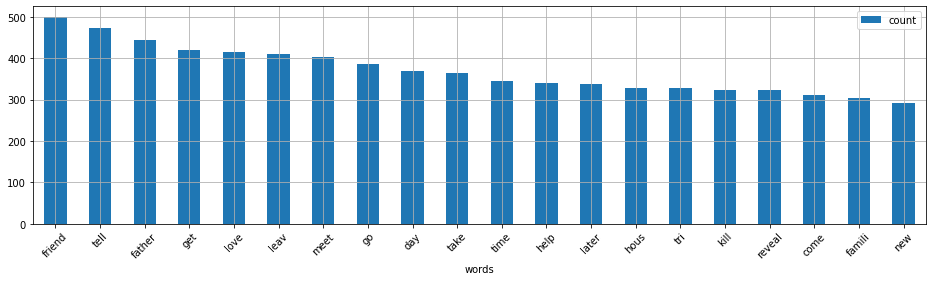

In [45]:
word_df.head(20).plot(x='words', kind='bar', figsize=(16,4), rot=45, grid=True)

LDA using BoW

In [46]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=4)

In [52]:
def show_model_topics(model, words_per_topic=10):
    for idx, topic in model.show_topics(num_words=words_per_topic, formatted=False):
        print(f'Topic {idx} | words & probability: {topic}')

In [53]:
show_model_topics(lda_model, words_per_topic=5)

Topic 0 | words & probability: [('friend', 0.008891518), ('love', 0.008689223), ('school', 0.007159238), ('leav', 0.006992268), ('year', 0.0063057556)]
Topic 1 | words & probability: [('tell', 0.0089802835), ('get', 0.007765469), ('leav', 0.0077217277), ('meet', 0.007194426), ('tri', 0.007026225)]
Topic 2 | words & probability: [('father', 0.012084464), ('friend', 0.0116389375), ('love', 0.010390623), ('day', 0.008691751), ('meet', 0.008162174)]
Topic 3 | words & probability: [('hous', 0.008744218), ('kill', 0.00828738), ('friend', 0.0078071766), ('tell', 0.0067682383), ('ghost', 0.006634203)]


In [54]:
# Some of the most frequent words show up in the topics, as expected from frequencies

### Train LDA using TF-IDF

In [55]:
from gensim import corpora, models

In [57]:
# Create corpuss

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [58]:
# Train LDA
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)

In [59]:
show_model_topics(lda_model_tfidf, words_per_topic=10)

Topic 0 | words & probability: [('jam', 0.0031709876), ('movi', 0.003166763), ('kill', 0.0029561569), ('meet', 0.0028727804), ('krishna', 0.0028228683), ('life', 0.0027685084), ('ami', 0.0027439748), ('wife', 0.0026386296), ('famili', 0.0026143012), ('year', 0.0025583897)]
Topic 1 | words & probability: [('love', 0.003607951), ('man', 0.003556659), ('film', 0.0035474547), ('girl', 0.0030152998), ('stori', 0.0029316086), ('dream', 0.00289833), ('comedi', 0.0028810448), ('ghost', 0.002784179), ('friend', 0.0027822496), ('villag', 0.002657474)]
Topic 2 | words & probability: [('villag', 0.005388833), ('father', 0.0034083622), ('school', 0.003274798), ('guy', 0.0028580315), ('kill', 0.00283646), ('girl', 0.002750024), ('polic', 0.002740946), ('love', 0.0026647595), ('set', 0.0025071308), ('wed', 0.0024822457)]
Topic 3 | words & probability: [('ghost', 0.0039045447), ('team', 0.003619682), ('hous', 0.0034885944), ('father', 0.0034885083), ('film', 0.00342924), ('love', 0.003328964), ('babi'

#### Testing and vizualization

In [61]:
#get random sentence

sample = movie_plots[movie_plots.index[23]]
txt = dictionary.doc2bow(preprocess(sample))

In [62]:
for index, score in sorted(lda_model[txt], reverse=True):
    print(f'\nScore: {score}\t \nTopic: {lda_model.print_topic(index, 10)}')


Score: 0.3474341332912445	 
Topic: 0.009*"hous" + 0.008*"kill" + 0.008*"friend" + 0.007*"tell" + 0.007*"ghost" + 0.007*"decid" + 0.006*"get" + 0.006*"time" + 0.006*"stori" + 0.006*"famili"

Score: 0.05951746180653572	 
Topic: 0.012*"father" + 0.012*"friend" + 0.010*"love" + 0.009*"day" + 0.008*"meet" + 0.008*"tell" + 0.008*"go" + 0.007*"get" + 0.007*"famili" + 0.006*"reveal"

Score: 0.5621135234832764	 
Topic: 0.009*"tell" + 0.008*"get" + 0.008*"leav" + 0.007*"meet" + 0.007*"tri" + 0.007*"take" + 0.007*"help" + 0.007*"go" + 0.006*"return" + 0.006*"school"

Score: 0.0309348925948143	 
Topic: 0.009*"friend" + 0.009*"love" + 0.007*"school" + 0.007*"leav" + 0.006*"year" + 0.006*"return" + 0.006*"tell" + 0.006*"new" + 0.006*"home" + 0.006*"take"


In [69]:
# Display score for lda tf-idf
for index, score in sorted(lda_model_tfidf[txt], reverse=True):
    print(f'\nScore: {score}\t \nTopic: {lda_model_tfidf.print_topic(index, 10)}')


Score: 0.8503271341323853	 
Topic: 0.005*"villag" + 0.003*"father" + 0.003*"school" + 0.003*"guy" + 0.003*"kill" + 0.003*"girl" + 0.003*"polic" + 0.003*"love" + 0.003*"set" + 0.002*"wed"

Score: 0.1454305350780487	 
Topic: 0.003*"jam" + 0.003*"movi" + 0.003*"kill" + 0.003*"meet" + 0.003*"krishna" + 0.003*"life" + 0.003*"ami" + 0.003*"wife" + 0.003*"famili" + 0.003*"year"


In [70]:
unseen_document = "The main character runs out of the house and tells his friends to get some help from someone infront of the school"

In [71]:
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

In [72]:
# Display score for lda tf-idf
for index, score in sorted(lda_model[bow_vector], key=lambda tup: tup[1], reverse=True):
    print(f'\nScore: {score}\t \nTopic: {lda_model.print_topic(index, 10)}')


Score: 0.9094260931015015	 
Topic: 0.009*"tell" + 0.008*"get" + 0.008*"leav" + 0.007*"meet" + 0.007*"tri" + 0.007*"take" + 0.007*"help" + 0.007*"go" + 0.006*"return" + 0.006*"school"

Score: 0.03024420328438282	 
Topic: 0.009*"hous" + 0.008*"kill" + 0.008*"friend" + 0.007*"tell" + 0.007*"ghost" + 0.007*"decid" + 0.006*"get" + 0.006*"time" + 0.006*"stori" + 0.006*"famili"

Score: 0.030232969671487808	 
Topic: 0.012*"father" + 0.012*"friend" + 0.010*"love" + 0.009*"day" + 0.008*"meet" + 0.008*"tell" + 0.008*"go" + 0.007*"get" + 0.007*"famili" + 0.006*"reveal"

Score: 0.030096735805273056	 
Topic: 0.009*"friend" + 0.009*"love" + 0.007*"school" + 0.007*"leav" + 0.006*"year" + 0.006*"return" + 0.006*"tell" + 0.006*"new" + 0.006*"home" + 0.006*"take"


In [74]:
# Display score for lda tf-idf
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: tup[1], reverse=True):
    print(f'\nScore: {score}\t \nTopic: {lda_model_tfidf.print_topic(index, 10)}')


Score: 0.9109127521514893	 
Topic: 0.004*"ghost" + 0.004*"team" + 0.003*"hous" + 0.003*"father" + 0.003*"film" + 0.003*"love" + 0.003*"babi" + 0.003*"wed" + 0.003*"marri" + 0.003*"win"

Score: 0.029831528663635254	 
Topic: 0.005*"villag" + 0.003*"father" + 0.003*"school" + 0.003*"guy" + 0.003*"kill" + 0.003*"girl" + 0.003*"polic" + 0.003*"love" + 0.003*"set" + 0.002*"wed"

Score: 0.029685717076063156	 
Topic: 0.003*"jam" + 0.003*"movi" + 0.003*"kill" + 0.003*"meet" + 0.003*"krishna" + 0.003*"life" + 0.003*"ami" + 0.003*"wife" + 0.003*"famili" + 0.003*"year"

Score: 0.029570026323199272	 
Topic: 0.004*"love" + 0.004*"man" + 0.004*"film" + 0.003*"girl" + 0.003*"stori" + 0.003*"dream" + 0.003*"comedi" + 0.003*"ghost" + 0.003*"friend" + 0.003*"villag"


In [ ]:
# TF-IDF match clearer matchings

In [77]:
import pyLDAvis.gensim

In [79]:
lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)

C:\Users\j.simbananiye\Documents\code\personal\knowledge-graphs\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
pyLDAvis.display(lda_display)

C:\Users\j.simbananiye\Documents\code\personal\knowledge-graphs\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
lda_tfidf_display = pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary, sort_topics=False)

C:\Users\j.simbananiye\Documents\code\personal\knowledge-graphs\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
pyLDAvis.display(lda_tfidf_display)

C:\Users\j.simbananiye\Documents\code\personal\knowledge-graphs\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
